In [1]:
import os
import sys
import time
import numpy as np
import math
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import skimage.measure
import plyfile
from plyfile import PlyData
from sklearn.neighbors import KDTree
import trimesh
import torch_geometric
from torch_geometric.nn import (NNConv, GMMConv, GraphConv, Set2Set)
from torch_geometric.nn import (SplineConv, graclus, max_pool, max_pool_x, global_mean_pool)
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

In [2]:
def load_pressure_predictor(load_directory):
    model = SplineCNN8Residuals(3)
    model.load_state_dict(torch.load(load_directory + "/cfdModel.nn"))
    return model.to("cuda:1").eval()

def load_latent_vectors(load_directory, checkpoint):
    filename = os.path.join(
        load_directory, checkpoint + ".pth"
    )
    if not os.path.isfile(filename):
        raise Exception(
            "The experiment directory ({}) does not include a latent code file"
            + " for checkpoint '{}'".format(load_directory, checkpoint)
        )
    data = torch.load(filename)
    return data["latent_codes"].cuda(1)

def load_decoder(load_directory, checkpoint):
    specs_filename = os.path.join(load_directory, "specs.json")
    if not os.path.isfile(specs_filename):
        raise Exception(
            'The experiment directory does not include specifications file "specs.json"'
        )
    specs = json.load(open(specs_filename))
    latent_size = specs["CodeLength"]
    decoder = Decoder(latent_size, **specs["NetworkSpecs"])
    decoder = torch.nn.DataParallel(decoder)
    saved_model_state = torch.load(os.path.join(load_directory, checkpoint +".pth"))
    decoder.load_state_dict(saved_model_state["model_state_dict"])
    decoder = decoder.module.cuda(1)
    decoder.eval()
    return decoder

In [3]:
from abc import ABC, abstractmethod

class objective_func(ABC):
    @abstractmethod
    def func(self, x):
        pass
    def dfunc(self, x):
        out = self.func(x)
        out.backward()
        return x.grad
    def get_optimal(self):
        return self.optimal
    def get_optimum(self):
        return self.optimum
    

class Decoder(nn.Module):
    def __init__(
        self,
        latent_size,
        dims,
        dropout=None,
        dropout_prob=0.0,
        norm_layers=(),
        latent_in=(),
        weight_norm=False,
        xyz_in_all=None,
        use_tanh=False,
        latent_dropout=False,
    ):
        super(Decoder, self).__init__()

        def make_sequence():
            return []

        dims = [latent_size + 3] + dims + [1]

        self.num_layers = len(dims)
        self.norm_layers = norm_layers
        self.latent_in = latent_in
        self.latent_dropout = latent_dropout
        if self.latent_dropout:
            self.lat_dp = nn.Dropout(0.2)

        self.xyz_in_all = xyz_in_all
        self.weight_norm = weight_norm

        for layer in range(0, self.num_layers - 1):
            if layer + 1 in latent_in:
                out_dim = dims[layer + 1] - dims[0]
            else:
                out_dim = dims[layer + 1]
                if self.xyz_in_all and layer != self.num_layers - 2:
                    out_dim -= 3

            if weight_norm and layer in self.norm_layers:
                setattr(
                    self,
                    "lin" + str(layer),
                    nn.utils.weight_norm(nn.Linear(dims[layer], out_dim)),
                )
            else:
                setattr(self, "lin" + str(layer), nn.Linear(dims[layer], out_dim))

            if (
                (not weight_norm)
                and self.norm_layers is not None
                and layer in self.norm_layers
            ):
                setattr(self, "bn" + str(layer), nn.LayerNorm(out_dim))

        self.use_tanh = use_tanh
        if use_tanh:
            self.tanh = nn.Tanh()
        self.relu = nn.ReLU()

        self.dropout_prob = dropout_prob
        self.dropout = dropout
        self.th = nn.Tanh()

    # input: N x (L+3)
    def forward(self, input):
        xyz = input[:, -3:]

        if input.shape[1] > 3 and self.latent_dropout:
            latent_vecs = input[:, :-3]
            latent_vecs = F.dropout(latent_vecs, p=0.2, training=self.training)
            x = torch.cat([latent_vecs, xyz], 1)
        else:
            x = input

        for layer in range(0, self.num_layers - 1):
            lin = getattr(self, "lin" + str(layer))
            if layer in self.latent_in:
                x = torch.cat([x, input], 1)
            elif layer != 0 and self.xyz_in_all:
                x = torch.cat([x, xyz], 1)
            x = lin(x)
            # last layer Tanh
            if layer == self.num_layers - 2 and self.use_tanh:
                x = self.tanh(x)
            if layer < self.num_layers - 2:
                if (
                    self.norm_layers is not None
                    and layer in self.norm_layers
                    and not self.weight_norm
                ):
                    bn = getattr(self, "bn" + str(layer))
                    x = bn(x)
                x = self.relu(x)
                if self.dropout is not None and layer in self.dropout:
                    x = F.dropout(x, p=self.dropout_prob, training=self.training)

        if hasattr(self, "th"):
            x = self.th(x)

        return x
class SplineBlock(nn.Module):
    def __init__(self, num_in_features, num_outp_features, mid_features, kernel=3, dim=3, batchnorm1=True):
        super(SplineBlock, self).__init__()
        self.batchnorm1 = batchnorm1
        self.conv1 = SplineConv(num_in_features, mid_features, dim, kernel, is_open_spline=False)
        if self.batchnorm1:
            self.batchnorm1 = torch.nn.BatchNorm1d(mid_features)
        self.conv2 = SplineConv(mid_features, 2 * mid_features, dim, kernel, is_open_spline=False)
        self.batchnorm2 = torch.nn.BatchNorm1d(2 * mid_features)
        self.conv3 = SplineConv(2 * mid_features + 3, num_outp_features, dim, kernel, is_open_spline=False)
  
    def forward(self, res, data):
        if self.batchnorm1:
            res = F.elu(self.batchnorm1(self.conv1(res, data['edge_index'], data['edge_attr'])))
        else:
            res = F.elu(self.conv1(res, data['edge_index'], data['edge_attr']))
        res = F.elu(self.batchnorm2(self.conv2(res, data['edge_index'], data['edge_attr'])))
#         res = F.elu(self.conv2(res, data.edge_index, data.edge_attr))
        res = torch.cat([res, data['x']], dim=1)
        res = self.conv3(res, data['edge_index'], data['edge_attr'])
        return res

class SplineCNN8Residuals(nn.Module):
    def __init__(self, num_features, kernel=3, dim=3):
        super(SplineCNN8Residuals, self).__init__()
        self.block1 = SplineBlock(num_features, 16, 8, kernel, dim)
        self.block2 = SplineBlock(16, 64, 32, kernel, dim)
        self.block3 = SplineBlock(64, 64, 128, kernel, dim)
        self.block4 = SplineBlock(64, 8, 16, kernel, dim)
        self.block5 = SplineBlock(11, 32, 16, kernel, dim)
        self.block6 = SplineBlock(32, 64, 32, kernel, dim)
        self.block7 = SplineBlock(64, 64, 128, kernel, dim)
        self.block8 = SplineBlock(75, 4, 16, kernel, dim)

    def forward(self, data):
        res = data['x']
        res = self.block1(res, data)
        res = self.block2(res, data)
        res = self.block3(res, data)
        res4 = self.block4(res, data)
        res = torch.cat([res4, data['x']], dim=1)
        res = self.block5(res, data)
        res = self.block6(res, data)
        res = self.block7(res, data)
        res = torch.cat([res, res4, data['x']], dim=1)
        res = self.block8(res, data)
        return res

def create_mesh(
    decoder, latent_vec, filename='', N=256, max_batch=32 ** 3, offset=None, scale=None
):
    ply_filename = filename

    decoder.eval()

    # NOTE: the voxel_origin is actually the (bottom, left, down) corner, not the middle
    voxel_origin = [-1, -1, -1]
    voxel_size = 2.0 / (N - 1)

    overall_index = torch.arange(0, N ** 3, 1, out=torch.LongTensor())
    samples = torch.zeros(N ** 3, 4)

    # transform first 3 columns
    # to be the x, y, z index
    samples[:, 2] = overall_index % N
    samples[:, 1] = (overall_index.long() // N) % N
    samples[:, 0] = ((overall_index.long() // N) // N) % N

    # transform first 3 columns
    # to be the x, y, z coordinate
    samples[:, 0] = (samples[:, 0] * voxel_size) + voxel_origin[2]
    samples[:, 1] = (samples[:, 1] * voxel_size) + voxel_origin[1]
    samples[:, 2] = (samples[:, 2] * voxel_size) + voxel_origin[0]

    num_samples = N ** 3

    samples.requires_grad = False
    head = 0

    while head < num_samples:
        sample_subset = samples[head : min(head + max_batch, num_samples), 0:3].cuda(1)
        num_subsample = min(max_batch, num_samples-head)
        latent_repeat = latent_vec.expand(num_subsample, -1)
        inputs = torch.cat([latent_repeat, sample_subset], 1)
        samples[head : min(head + max_batch, num_samples), 3] = \
                decoder(inputs).squeeze(1).detach().cpu()
        head += max_batch
        
    sdf_values = samples[:, 3].reshape(N, N, N).data.cpu()

    return convert_sdf_samples_to_ply(
        sdf_values,
        voxel_origin,
        voxel_size,
        ply_filename + ".ply",
        offset,
        scale,
    )

def convert_sdf_samples_to_ply(
    pytorch_3d_sdf_tensor,
    voxel_grid_origin,
    voxel_size,
    ply_filename_out,
    offset=None,
    scale=None,
):
    """
    Convert sdf samples to .ply

    :param pytorch_3d_sdf_tensor: a torch.FloatTensor of shape (n,n,n)
    :voxel_grid_origin: a list of three floats: the bottom, left, down origin of the voxel grid
    :voxel_size: float, the size of the voxels
    :ply_filename_out: string, path of the filename to save to

    This function adapted from: https://github.com/RobotLocomotion/spartan
    """

    numpy_3d_sdf_tensor = pytorch_3d_sdf_tensor.numpy()

    verts, faces, normals, values = skimage.measure.marching_cubes_lewiner(
        numpy_3d_sdf_tensor, level=0.0, spacing=[voxel_size] * 3
    )

    # transform from voxel coordinates to camera coordinates
    # note x and y are flipped in the output of marching_cubes
    mesh_points = np.zeros_like(verts)
    mesh_points[:, 0] = voxel_grid_origin[0] + verts[:, 0]
    mesh_points[:, 1] = voxel_grid_origin[1] + verts[:, 1]
    mesh_points[:, 2] = voxel_grid_origin[2] + verts[:, 2]

    # apply additional offset and scale
    if scale is not None:
        mesh_points = mesh_points / scale
    if offset is not None:
        mesh_points = mesh_points - offset

    # try writing to the ply file

    num_verts = verts.shape[0]
    num_faces = faces.shape[0]

    verts_tuple = np.zeros((num_verts,), dtype=[("x", "f4"), ("y", "f4"), ("z", "f4")])
    norms_tuple = np.zeros((num_verts,), dtype=[("x", "f4"), ("y", "f4"), ("z", "f4")])

    for i in range(0, num_verts):
        verts_tuple[i] = tuple(mesh_points[i, :])
        norms_tuple[i] = tuple(normals[i, :])

    faces_building = []
    for i in range(0, num_faces):
        faces_building.append(((faces[i, :].tolist(),)))
    faces_tuple = np.array(faces_building, dtype=[("vertex_indices", "i4", (3,))])

    el_verts = plyfile.PlyElement.describe(verts_tuple, "vertex")
    el_faces = plyfile.PlyElement.describe(faces_tuple, "face")
    el_norms = plyfile.PlyElement.describe(norms_tuple, "normals")

    ply_data = plyfile.PlyData([el_verts, el_faces, el_norms])
    return ply_data

def compute_lift_faces_diff(mesh, preds):
    pressures = torch.mean(preds[mesh['face'], 0], axis=0)

    # TODO: cahnge to x if needed
    pos = mesh['x']
    cross_prod = (pos[mesh['face'][1]] - pos[mesh['face'][0]]).cross(
                  pos[mesh['face'][2]] - pos[mesh['face'][0]])
    area = -cross_prod[:, 0] / 2
    lift = torch.mul(pressures, area)
    return torch.sum(lift[~torch.isnan(lift)])

def boundsLoss(points, box=[(-1, 1, 0)]):
    loss = 0
    for l, r, i in box:
        loss +=  torch.mean(F.relu(-points[:, i] + l))  \
               + torch.mean(F.relu( points[:, i] - r))
    return loss

def innerBoundsLoss(points, r=1, center=(0, 0, 0)):
    radiuses = torch.sum( (points - torch.Tensor(center).to('cuda:1')) ** 2 , dim=1)
    return torch.mean(F.relu(r - radiuses))

def calculate_loss(mesh, local_preds, constraint_rad=0.1):
    loss = compute_lift_faces_diff(mesh, local_preds)
    first = loss.clone().detach().cpu().numpy()
    loss += boundsLoss(mesh['x'], box=[(-0.6, 0.6, 0)])
    second = loss.clone().detach().cpu().numpy()
    loss += innerBoundsLoss(mesh['x'], r=constraint_rad**2, center=(-0.05, 0.05, 0))  \
          + innerBoundsLoss(mesh['x'], r=(constraint_rad / 2)**2, center=(0.3, 0, 0))
    print("three parts (321) of loss: %.3f, %.3f, %.3f"%(loss.detach().cpu().numpy() - second, second-first, first))
    return loss

def transformPoints(points, AvgTransform):
    matrix = torch.cuda.FloatTensor(AvgTransform).cuda(1)
    column = torch.zeros((len(points), 1), device="cuda:1") + 1
    stacked = torch.cat([points, column], dim=1)
    transformed = torch.matmul(matrix, stacked.t()).t()[:, :3]
    return transformed

def transform_mesh(points, ply_mesh, AvgTransform):
    transformed_points = transformPoints(points, AvgTransform)
    
    edges = trimesh.geometry.faces_to_edges(ply_mesh['face']['vertex_indices'])
    np_points = transformed_points.cpu().detach().numpy()
    edge_attr = [np_points[a] - np_points[b] for a, b in edges]
    mesh = {'x': transformed_points, 
        'face':torch.tensor(ply_mesh['face']['vertex_indices'], dtype=torch.long).to('cuda:1').t(),
        'edge_attr':torch.tensor(edge_attr, dtype=torch.float).to('cuda:1'),
        'edge_index':torch.tensor(edges, dtype=torch.long).t().contiguous().to('cuda:1')
        }
    return mesh


def decode_sdf(decoder, latent_vector, queries):
    num_samples = queries.shape[0]

    if latent_vector is None:
        inputs = queries
    else:
        latent_repeat = latent_vector.expand(num_samples, -1)
        inputs = torch.cat([latent_repeat, queries], 1)

    sdf = decoder(inputs)

    return sdf

def get_trimesh_from_torch_geo_with_colors(mesh, preds, vmin=-8, vmax=8):
    norm = mpl.colors.Normalize(vmin= vmin, vmax=vmax)
    cmap = cm.hot
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    
    verticies = mesh['x'].cpu().detach()
    faces = mesh['face'].t().cpu().detach()
    return trimesh.Trimesh(vertices=verticies, faces=faces, 
                           vertex_colors=list(map(lambda c: m.to_rgba(c),  preds[:, 0].cpu().detach())))




In [4]:
DIR_to_load_data = '../Non-convex/starting_data'
experiment_directory = "data_for_this_experiments"

model = load_pressure_predictor(DIR_to_load_data)

decoder = load_decoder(DIR_to_load_data, "decoderModel")

latent_vectors = load_latent_vectors(DIR_to_load_data, "latentCodes").detach()

AvgTransform = np.load(DIR_to_load_data + "/avg_trans_matrix.npy") #computeAvgTransform()

LATENT_TO_OPTIMIZE = latent_vectors[32]
LATENT_KD_TREE = KDTree(np.array([lv.cpu().detach().numpy()[0] for lv in latent_vectors]))
# /cvlabdata2/home/artem/Data/cars_remeshed_dsdf/transforms/"

In [5]:
latent_vectors = latent_vectors.cuda(1)

In [7]:
def visual_Mesh(ilatent, N):
    with torch.no_grad():
        ply_mesh = create_mesh(decoder,
                            ilatent,
                            N=N,
                            max_batch=int(2 ** 18))
        points = torch.cuda.FloatTensor(np.hstack(( ply_mesh['vertex']['x'][:, None], 
                                            ply_mesh['vertex']['y'][:, None], 
                                            ply_mesh['vertex']['z'][:, None]))).cuda(1)
        scaled_mesh = transform_mesh(points, ply_mesh, AvgTransform)
        pressure_field = predictor(scaled_mesh)
        loss = compute_lift_faces_diff(scaled_mesh, pressure_field)  
    print("latent loss. %f "%(loss))
    return loss

In [7]:
loss_all = np.load("check_loss_sign/loss_all_latent.npy", allow_pickle=True)
loss_all.shape

(1205,)

In [8]:
loss_all = [i.item() for i in loss_all]

In [9]:
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KDTree
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
#%matplotlib notebook
%matplotlib inline

In [10]:
torch.svd(data)

NameError: name 'data' is not defined

In [100]:
data = latent_vectors.squeeze().cpu()
pca_20 = PCA(n_components=200)
pca_20.fit(data)
pca_result_20 = pca_20.transform(data)
LATENT_KD_TREE_20d = KDTree(pca_result_20)

In [101]:
pca_result_20 = latent_vectors.squeeze().cpu().numpy()
LATENT_KD_TREE_20d = KDTree(pca_result_20)

In [12]:
pca_result_20.shape

torch.Size([1205, 256])

In [13]:
def scatter2d(data):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    ax.set_ylim([-0.8, 0.8])
    ax.set_xlim([-0.8, 0.8])
    plt.scatter(data[:,0], data[:,1], s=10, c=np.arange(data.shape[0]))
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    plt.colorbar(cax=cbar_ax)

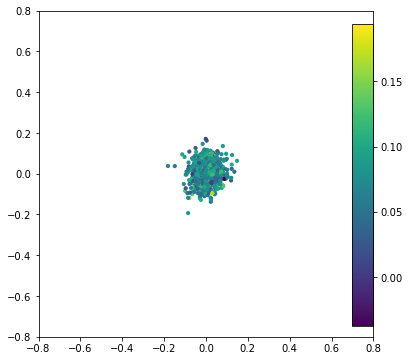

In [14]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_ylim([-0.8, 0.8])
ax.set_xlim([-0.8, 0.8])
plt.scatter(pca_result_20[:,0], pca_result_20[:,1], s=10, c=loss_all)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(cax=cbar_ax)

In [ ]:
def func(latent):
    distances, indeces = LATENT_KD_TREE.query(latent.cpu().detach().reshape(1,-1), k=10)
    return 0.2 * torch.sum((latent - latent_vectors[indeces.squeeze()]) ** 2, dim=2).mean()

In [ ]:
pca_result_20.shape

In [102]:
def func20d_n(latent):
    distances, indeces = LATENT_KD_TREE_20d.query(latent.reshape(1,-1), k=10)
    return 0.2 * np.sum((latent - pca_result_20[indeces.squeeze()]) ** 2, axis=1).mean()

In [104]:
func20d_n(np.random.randn(256))

53.519057281770166

In [98]:
func20d_n(np.array([0.08,0.08]))

ValueError: query data dimension must match training data dimension

In [50]:
func2d_n(lat32) * 1e4

2.7877270175314663

In [18]:
lim = 0.8
n = 100
x = np.linspace(-lim, lim, n)
z = []
for i in x:
    z_line = []
    for j in x:
        z_line.append(func20d_n(np.array([j,i])))
    z.append(z_line)
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
fig.update_layout(autosize=False,
              scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
              width=500, height=500,
              margin=dict(l=65, r=50, b=65, t=90))

In [17]:
#fig = px.scatter_3d(x=pca_result_2[:,0], y=pca_result_2[:,1], z=loss_all, color=loss_all)
#fig.show()

In [ ]:
loss_all = []
i = 0
for lat in latent_vectors:
    start = time.time()
    loss = visual_Mesh(lat, 256)
    end = time.time()
    i += 1
    print("%d th latent, time: %.2f"%(i, end-start))
    loss_all.append(loss)
    np.save("check_loss_sign/loss_all_latent.npy", loss_all)

In [7]:
def method4_to_arbitatry_loss(points, ply_mesh, model, constraint_rad=0.1, axis=0):
    initial_dir = points.grad.clone()
    points.grad.data.zero_()
    #points.requires_grad_(False)
    mesh = transform_mesh(points, ply_mesh, AvgTransform)
    #mesh['x'] = mesh['x'].detach().requires_grad_(True)
    local_preds = model(mesh)
    loss = calculate_loss(mesh, local_preds, constraint_rad=constraint_rad)
    loss.backward()

    sign = [-p1.dot(p2) for p1, p2 in zip(initial_dir, points.grad)]
    
    return sign, loss, local_preds, mesh

def optimize_shape_deepSDF(decoder, latent, 
                           num_iters=100, num_neignours_constr=10,
                           lr=0.2, decreased_by=2, adjust_lr_every=10, alpha_penalty=0.05,
                           multiplier_func=method4_to_arbitatry_loss, verbose=None, save_to_dir=None, N=256, optimizer=None):

    def adjust_learning_rate(
        initial_lr, optimizer, num_iterations, decreased_by, adjust_lr_every
    ):
        lr = initial_lr * ((1 / decreased_by) ** (num_iterations // adjust_lr_every)) \
                        * ((punch_lr_at_reindex_by) ** (num_iterations // reindex_latent_each))
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        return lr
    
    #ref_latent = latent.clone().detach()
    decoder.eval()
    latent = latent.clone().detach()
    optimizer.init(latent)
    latent = optimizer.step(0, latent, None, None)
    print("\n")
    phy_loss_plot = []
    penalty_plot = []
    latent_plot = []
    math_loss_plot = []
    for i in range(1, num_iters):
        start = time.time()
        
        #cur_rl = adjust_learning_rate(lr, inner_opt, i, decreased_by, adjust_lr_every)
        latent = latent.detach().reshape(1,-1).requires_grad_(True)
        #print("initial loss: ", func(latent))
        '''
        try:
            with torch.no_grad():
                ply_mesh = create_mesh(decoder,
                                        latent,
                                        N=N,
                                        max_batch=int(2 ** 18),
                                        offset=None,
                                        scale=None)
        except e:
            print("out of space", e)
            continue
        end = time.time()
        print("mesh time: %.1f "%(end-start))
        
        points = torch.tensor(np.hstack(( ply_mesh['vertex']['x'][:, None], 
                                          ply_mesh['vertex']['y'][:, None], 
                                          ply_mesh['vertex']['z'][:, None]))).cuda(1)
        
        points.requires_grad = True

        sdf_value = decode_sdf(decoder, latent.detach(), points)
        sdf_value.backward(torch.ones([len(points), 1], dtype=torch.float32).cuda(1))

        
        mults, loss_value, preds, transformed_mesh = multiplier_func(points, ply_mesh)         
        multipliers = torch.cuda.FloatTensor(mults).cuda(1)
    
        sdf_value = torch.squeeze(decode_sdf(decoder, latent, points.detach()))
    
        final_loss = torch.sum(sdf_value * multipliers)
        
        
        final_loss.backward()
        
        '''


        #first_deri = torch.norm(latent.grad).item()
        #first_d = latent.grad.clone().squeeze()
        
        
        # Soft-constraints
        #distances, indeces = LATENT_KD_TREE.query(latent.cpu().detach().reshape(1,-1), k=num_neignours_constr)
        #apenalty = alpha_penalty * torch.sum((latent.reshape(1,-1) - latent_vectors[indeces.squeeze()]) ** 2, dim=2).mean()
        
        apenalty = alpha_penalty * func2d(latent)
        
        apenalty.backward()
        sum_d = latent.grad.squeeze()
        #second_d = sum_d - first_d
        #second_deri = torch.norm(second_d).item()

    
        math_loss = apenalty
        
        
        math_loss_plot.append(math_loss.item())
        #phy_loss_plot.append(loss_value.item())
        latent_plot.append(latent.detach().cpu().numpy().squeeze())
        #np.save(os.path.join(save_to_dir, "phy_loss_plot.npy"), phy_loss_plot)    
        np.save(os.path.join(save_to_dir, "latent_series.npy"), latent_plot)    
        np.save(os.path.join(save_to_dir, "math_loss_plot.npy"), math_loss_plot)   
        

        latent = optimizer.step(i, latent, math_loss, sum_d)
        
        end_end = time.time()
        
        print("backward time: %.2f"%(end_end-start))
        
        
        if verbose is not None and i % verbose == 0:
            print('Iter ', i)
            #print("gradient: first %.3f second %.3f, full %.3f, angle %.2f "%(first_deri, second_deri, \
            #    torch.norm(sum_d), 90 / np.pi * torch.acos(first_d.dot(second_d) / torch.norm(first_d)/torch.norm(second_d))))
            #print('phys Loss: %.5f'%(loss_value.item()*1e4))
            #print("x: ", x0.detach().cpu().numpy())
            print("math loss: ", math_loss.item())
            #print("arti loss:", final_loss.item()*1e4)
            #print('apenality: %f'%(apenalty.item()*1e4))
        print("\n")
        #if i > 2 and np.abs(loss_plot[-1] - loss_plot[-2]) < 1e-4:
            #print("one time of low progress!")
            #break
        
    return phy_loss_plot, math_loss_plot, penalty_plot, np.array(latent_plot)



def make_full_transformation(initial_latent, experiment_name, N, verbose, adjust_lr_every, decreased_by, lr,
                             decoder, model, optimizer= None, alpha_penalty=0.05, constraint_rad=0.1, num_iters=200):
    '''
    kwargs:
        num_iters=1000, 
        adjust_lr_every=10, 
        decreased_by=1.2,
        lr=0.005
        verbose=10,
    '''

    #ref_points = get_points_from_latent(decoder, ref_latent, N=128)
    save_to_dir = experiment_name
    if not os.path.exists(save_to_dir):
        os.makedirs(save_to_dir)

    #np.save(os.path.join(save_to_dir, "target_verts.npy"), ref_points)

    return optimize_shape_deepSDF(decoder=decoder, latent=initial_latent, N=N, num_iters=num_iters, optimizer=optimizer, 
                                  multiplier_func=lambda x, y: 
                                        method4_to_arbitatry_loss(x, y, model, 
                            constraint_rad=constraint_rad, axis=0),
                                           alpha_penalty=alpha_penalty,
                                           save_to_dir=save_to_dir, verbose=verbose)
    

In [15]:
class line_search():
    def __init__(self, alpha=1, beta=0.1):
        self.alpha = alpha
        self.beta = beta
        self.max_iter = 100
        self.tol = 1e-2
        self.verbose = False
        self.record = False
        self.TAO = 0.5
        self.pre_x = None
     
    def set_parameters(self, paras):
        self.paras = paras
        self.x0 = paras['x0']
        self.alpha = paras['alpha']
        self.beta = paras['beta']
        self.max_iter = paras['max_iter']
        self.tol = paras['tol']
        self.verbose = True if 'verbose' not in paras.keys() else paras['verbose']
        self.record = True if 'record' not in paras.keys() else paras['record']
        
    def init(self, a, b):
        self.alpha_ = a
        self.BETA = b
        self.TAO = 0.5
        self.cycle = 15
        
    def step(self, i, x, val, grad):
        if(i % self.cycle != 1 ):
            print("compare: ", val.item() , " and  ", (self.pre_val + self.alpha_ * self.pre_grad2).item(), "p2", self.pre_grad2.item())
        if i % self.cycle == 1 or val < (self.pre_val + self.alpha_ * self.pre_grad2):
            #val.backward()
            print(i, "***********one time of hit")
            #print("xx, ", x, val)
            #grad = x.grad
            #print("!!!!!  new grad: ", grad.cpu().numpy().shape)
            self.pre_grad = -grad
            #print("grad", grad.squeeze()[:10], "p2 norm2: ", -torch.norm(grad)**2)
            self.pre_grad2 = -grad @ grad.t() * self.BETA
            self.pre_val = val 
            self.pre_x = x
            return x + self.alpha_ * -grad
        else:
            self.alpha_ *= self.TAO
            print(i, "<<<<<<<<<<<<<<<< miss! ",self.alpha_)
            #print("pre_x ", self.pre_x.detach().cpu().numpy())
            #print("alpha_ ", self.alpha_)
            #print("grad: ", self.pre_grad.detach().cpu().numpy())
            #print("multi: ", (self.alpha_*self.pre_grad).detach().cpu().numpy())
            return self.pre_x + self.alpha_*self.pre_grad

In [80]:
class cma_es():
    def __init__(self, dim=2):
        self.DIM = dim
        paras = {'x0': torch.zeros((dim,)),
                 'std': torch.ones((dim,)) * 3, 
                 'tol': 1e-5, 
                 'adjust_func': None, 
                 'record': False, 
                 'verbose': False}
        self.set_parameters(paras)
    def set_parameters(self, paras):
        self.paras = paras
        self.x0 = paras['x0'] 
        self.std = paras['std']
        self.tol = paras['tol']
        self.adjust_func = paras['adjust_func']
        self.max_iter = 400 if 'max_iter' not in paras.keys() else paras['max_iter']
        # set none to use default value 
        self.cluster_size = None if 'cluster_size' not in paras.keys() else paras['cluster_size']
        self.survival_size = None if 'survival_size' not in paras.keys() else paras['survival_size']
        self.record = True if 'record' not in paras.keys() else paras['record']
        self.verbose = True if 'verbose' not in paras.keys() else paras['verbose']
    def update_mean(self, xs):
        #print("weigths: ", self.WEIGHTS)
        #print("xs:", xs)
        #WEIGHTS = torch.tensor([1.0, 0.0, 0.0]).cuda()
        #print("before: ", func(self.mean.reshape(1,-1)))
        #print("shape: ", self.WEIGHTS.shape, WEIGHTS.shape, xs.shape)

        mean = (torch.matmul(self.WEIGHTS.reshape(1,-1), xs)).reshape(self.DIM, 1)
        
        #print("after: ", func(mean.reshape(1,-1)))
        #print("best: ", func(xs[0,:]), "second: ", func(xs[1,:]), "third: ", func(xs[2,:]))
        return mean
    def update_ps(self):
        return (1 - self.CS) * self.ps + torch.sqrt(self.CS * (2 - self.CS) * self.MUEFF) \
    * self.invsqrtC @ (self.mean - self.mean_old) / self.sigma 
    def update_pc(self, iter_):
        hsig = (torch.norm(self.ps) / torch.sqrt(1 - (1 - self.CS)**    \
        (2 * iter_/self.LAMBDA_)) / self.chiN < 1.4 + 2/(self.DIM + 1)).int()
        return (1 - self.CC) * self.pc + hsig * torch.sqrt(self.CC * (2 - self.CC) * \
                        self.MUEFF) * (self.mean - self.mean_old) / self.sigma
    def update_C(self, iter_, xs):
        hsig = (torch.norm(self.ps) / torch.sqrt(1 - (1 - self.CS)**(2 * iter_/  \
                self.LAMBDA_)) / self.chiN < (1.4 + 2/(self.DIM + 1))).int()
        artmp = (1 / self.sigma) * (xs - self.mean_old.reshape(1, self.DIM))
        return (1 - self.C1 - self.CMU) * self.c + self.C1 *  \
                (self.pc * self.pc.transpose(1,0) + (1 - hsig) * self.CC * \
                (2 - self.CC) * self.c) + self.CMU * artmp.transpose(1,0) @  \
                torch.diag(self.WEIGHTS) @ artmp
    def update_sigma(self):
        return self.sigma * torch.exp((self.CS / self.DAMPS) * (torch.norm(self.ps)/ self.chiN - 1))

    def init(self, latent):
        latent = latent.squeeze()
        # User defined input parameters 
        self.DIM = latent.shape[0]
        
        # the size of solutions group
        self.LAMBDA_ = 4 + int(3 * torch.log(torch.tensor(self.DIM * 1.0))) if self.cluster_size == None else self.cluster_size  
        # only best "mu" solutions are used to generate iterations
        self.MU = int(self.LAMBDA_ / 2) if self.survival_size == None else self.survival_size
        # used to combine best "mu" solutions                                               
        self.WEIGHTS = torch.log(torch.tensor(self.MU + 1/2)) - torch.log(torch.arange(self.MU, dtype=torch.float) + 1) 
        self.WEIGHTS = (self.WEIGHTS / torch.sum(self.WEIGHTS)).cuda(1)   
        #self.WEIGHTS = torch.tensor([1.0, 0.0]).cuda(1)
        self.MUEFF = 1 / torch.sum(self.WEIGHTS**2) 

        # Strategy parameter setting: Adaptation
        # time constant for cumulation for C
        self.CC = (4 +self. MUEFF / self.DIM) / (self.DIM + 4 + 2 * self.MUEFF / self.DIM)  
        # t-const for cumulation for sigma control
        self.CS = (self.MUEFF + 2) / (self.DIM + self.MUEFF + 5)  
        # learning rate for rank-one update of C
        self.C1 = 2 / ((self.DIM + 1.3)**2 + self.MUEFF)    
        # and for rank-mu update
        self.CMU = min(1 - self.C1, 2 * (self.MUEFF - 2 + 1 / self.MUEFF) / ((self.DIM + 2)**2 + self.MUEFF))  
        # damping for sigma, usually close to 1  
        self.DAMPS = 1 + 2 * max(0, torch.sqrt((self.MUEFF - 1)/( self.DIM + 1)) - 1) + self.CS     
        self.chiN = self.DIM**0.5 * (1 - 1/(4 * self.DIM) + 1 / (21 * self.DIM**2))  

        
        self.sigma = 0.3
        self.d = self.std / self.sigma
        self.mean = latent.detach().reshape(self.DIM,1)
        # Initialize dynamic (internal) strategy parameters and constants
        # evolution paths for C and sigma
        self.pc = torch.zeros((self.DIM, 1), device=torch.device('cuda:1'))     
        self.ps = torch.zeros((self.DIM, 1), device=torch.device('cuda:1')) 
        # B defines the coordinate system
        self.b = torch.eye(int(self.DIM), device=torch.device('cuda:1'))       
        # covariance matrix C
        self.c = self.b * torch.diag(self.d**2) * self.b.transpose(1, 0)
        # C^-1/2 
        self.invsqrtC = self.b * torch.diag(self.d**-1) * self.b.transpose(1, 0)
        # expectation of ||N(0,I)|| == norm(randn(N,1)) 
        self.xs = []
        self.fs = []
        self.j = 0
        self.cycle = 50
        self.ls = line_search()
        self.ls.init(0.5, 0.01)
    def add_inner(self, ls):
        self.ls = ls
    def step(self, i, x, val, grad):
        if i % self.cycle != 0 :
            #print("before inner: ", x.detach().cpu().numpy())
            #print("before adam loss: ", func(x))
            opt = torch.optim.SGD([x], lr=0.2)
            opt.step()
            #print("after adam loss: ", func(x))
            #x = self.ls.step(i, x, val, grad)
            #print("What can I do? after inner: ", x.detach().cpu().numpy())
            return x.reshape(1,-1)
        elif i != 0:
            self.xs.append(x.detach().squeeze().clone())
            self.fs.append(val)
            print("x_after: ", x[0,:100])
            #old = x.clone()
            #opt = torch.optim.SGD([x], lr=0.2)
            #opt.step()
            #return x
        if i % (self.cycle * self.LAMBDA_) == 0 and i != 0:
            print("length: ", len(self.fs))
            idx = torch.argsort(torch.tensor(self.fs))
            x_ascending = torch.stack(self.xs)[idx]
            print("x_ascend: ", x_ascending[0][:10])
            print("x_ascend shape: ", x_ascending.shape)
            print("x_ascend shape: ", x_ascending[:self.MU].shape)
            print("fx: ", self.fs)
            print("idx: ", idx)
            # update the parameter for next iteration
            self.mean_old = self.mean.clone()
            self.mean = self.update_mean(x_ascending[:self.MU])
            
            print("")
            print("new mean: ", self.mean[:10])
            self.ps = self.update_ps()
            self.pc = self.update_pc(int(i/self.LAMBDA_))
            self.sigma = self.update_sigma()
            self.c = self.update_C(int(i/self.LAMBDA_), x_ascending[:self.MU])
            self.c = (torch.triu(self.c) + torch.triu(self.c, 1).transpose(1,0))
            self.d, self.b = torch.eig(self.c, eigenvectors=True)
            print("eig: ", self.d[:10, 0].detach().cpu().numpy())
            self.d = torch.sqrt(self.d[:,0])
            self.invsqrtC = self.b @ torch.diag(self.d**-1) @ self.b.transpose(1,0)
            self.xs = []
            self.fs = []
            self.j += 1
            print("********** %d th iter of CMA completed************"%(self.j))
        print("eig, sigma: ", self.sigma, self.d[:10].detach().cpu().numpy())
        x_new = (self.mean + self.sigma * self.b @ torch.diag(self.d)  \
                 @ torch.randn(self.DIM, 1).cuda(1))
        print("x_before: ", x_new[:10])
        '''
        print("new sampled position: ", x_new)
        print("should be mean 0:  ", (self.sigma * self.b @ torch.diag(self.d)  \
                 @ torch.randn(self.DIM, 1).cuda()).cpu().numpy().mean(), \
              (self.sigma * self.b @ torch.diag(self.d)  \
                 @ torch.randn(self.DIM, 1).cuda()).cpu().numpy()[:20])
        '''
        print("<<<<<<<<<<<<<< new sampled position")
        return x_new.reshape(1, self.DIM)

In [9]:
import cma

In [105]:
func20d_n(lat32.cpu().numpy())

0.07974370121955872

In [6]:
pca_result_20 = latent_vectors.squeeze().cpu()
LATENT_KD_TREE_20d = KDTree(pca_result_20)

pca_result_20_t = torch.tensor(pca_result_20, dtype=torch.float).cuda(1)
def func2d(latent):
    distances, indeces = LATENT_KD_TREE_20d.query(latent.cpu().detach().reshape(1,-1), k=10)
    return 0.2 * torch.sum((latent - pca_result_20_t[indeces.squeeze()]) ** 2, dim=1).mean() 

In [7]:
N = 256
IN_N = 40
lat32 = pca_result_20[32]

def func_drag(latent):
    latent = torch.tensor(latent, dtype=torch.float).cuda(1).reshape(1,-1)
    try:
        with torch.no_grad():
            ply_mesh = create_mesh(decoder,
                                    latent,
                                    N=N,
                                    max_batch=int(2 ** 18),
                                    offset=None,
                                    scale=None)
    except e:
        print("************out of space***********", e)
    points = torch.tensor(np.hstack(( ply_mesh['vertex']['x'][:, None], 
                                      ply_mesh['vertex']['y'][:, None], 
                                      ply_mesh['vertex']['z'][:, None]))).cuda(1)
    mesh = transform_mesh(points, ply_mesh, AvgTransform)
    local_preds = model(mesh)
    loss = calculate_loss(mesh, local_preds, constraint_rad=0.05)
    return loss.item()

def func_grad(latent):
    try:
        with torch.no_grad():
            ply_mesh = create_mesh(decoder,
                                    latent,
                                    N=N,
                                    max_batch=int(2 ** 18),
                                    offset=None,
                                    scale=None)
    except e:
        print("************out of space***********", e)
    points = torch.tensor(np.hstack(( ply_mesh['vertex']['x'][:, None], 
                                      ply_mesh['vertex']['y'][:, None], 
                                      ply_mesh['vertex']['z'][:, None]))).cuda(1)
    points.requires_grad = True
    sdf_value = decode_sdf(decoder, latent.detach(), points)
    sdf_value.backward(torch.ones([len(points), 1], dtype=torch.float32).cuda(1))
    
    initial_dir = points.grad.clone()
    points.grad.data.zero_()
    mesh = transform_mesh(points, ply_mesh, AvgTransform)
    local_preds = model(mesh)
    loss = calculate_loss(mesh, local_preds, constraint_rad=constraint_rad)
    loss.backward()
    sign = [-p1.dot(p2) for p1, p2 in zip(initial_dir, points.grad)]
    
    multipliers = torch.cuda.FloatTensor(sign).cuda(1)
    sdf_value = torch.squeeze(decode_sdf(decoder, latent, points.detach()))
    final_loss = torch.sum(sdf_value * multipliers)
    return final_loss

def inner_opt(x):
    x = torch.tensor(x, dtype=torch.float).cuda(1).requires_grad_(True)
    opt = torch.optim.SGD([x], lr=0.2)
    while i < IN_N:
        loss = func_grad(x)
        loss.backward()
        opt.step()
        x.grad.zero_()
        i += 1
        if i == IN_N:
            fit = loss.item()
    return x, fit

In [ ]:
x0, sigma0 = lat32.cpu().numpy(), 0.05
es = cma.CMAEvolutionStrategy(x0, sigma0)
i = 0
while i < 10:
    X = es.ask()
    new_x_fit = [inner_opt(x) for x in X]
    X, fitness = zip(*new_x_fit)
    es.tell(X, fitness)
    es.disp()
    i += 1

In [10]:
x0, sigma0 = lat32.cpu().numpy(), 0.05
es = cma.CMAEvolutionStrategy(x0, sigma0)
i = 0
while i < 10:
    X = es.ask()
    fitness = [func_drag(x) for x in X]
    es.tell(X, fitness)
    es.disp(1)
    i += 1

(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 256 (seed=126684, Wed Sep  2 06:08:34 2020)
three parts (321) of loss: 0.000, 0.000, 0.066
three parts (321) of loss: 0.000, 0.000, 0.086
three parts (321) of loss: 0.000, 0.000, 0.092
three parts (321) of loss: 0.000, 0.000, 0.094
three parts (321) of loss: 0.000, 0.000, 0.050
three parts (321) of loss: 0.000, 0.000, 0.086
three parts (321) of loss: 0.000, 0.000, 0.070
three parts (321) of loss: 0.000, 0.000, 0.070
three parts (321) of loss: 0.000, 0.000, 0.072
three parts (321) of loss: 0.000, 0.000, 0.077
three parts (321) of loss: 0.000, 0.000, 0.062
three parts (321) of loss: 0.000, 0.000, 0.087
three parts (321) of loss: 0.000, 0.000, 0.074
three parts (321) of loss: 0.000, 0.000, 0.052
three parts (321) of loss: 0.000, 0.000, 0.095
three parts (321) of loss: 0.000, 0.000, 0.077
three parts (321) of loss: 0.000, 0.000, 0.093
three parts (321) of loss: 0.000, 0.000, 0.061
three parts (321) of loss: 0.000, 0.000, 0.066
three parts (

three parts (321) of loss: 0.000, 0.000, -0.000
three parts (321) of loss: 0.000, 0.000, -0.019
three parts (321) of loss: 0.000, 0.000, 0.013
three parts (321) of loss: 0.000, 0.000, -0.033
three parts (321) of loss: 0.000, 0.000, -0.021
three parts (321) of loss: 0.000, 0.000, 0.002
three parts (321) of loss: 0.000, 0.000, 0.001
three parts (321) of loss: 0.000, 0.000, 0.012
three parts (321) of loss: 0.000, 0.000, -0.021
three parts (321) of loss: 0.000, 0.000, -0.008
three parts (321) of loss: 0.000, 0.000, 0.016
three parts (321) of loss: 0.000, 0.000, -0.026
three parts (321) of loss: 0.000, 0.000, 0.001
three parts (321) of loss: 0.000, 0.000, -0.002
three parts (321) of loss: 0.000, 0.000, 0.005
three parts (321) of loss: 0.000, 0.000, 0.005
three parts (321) of loss: 0.000, 0.000, 0.001
three parts (321) of loss: 0.000, 0.000, -0.008
three parts (321) of loss: 0.000, 0.000, 0.005
three parts (321) of loss: 0.000, 0.000, -0.001
    9    180 -3.284173458814621e-02 1.0e+00 4.39e-

In [14]:
np.save("cma_lib_res10.npy", X)

In [16]:
np.save("cma_lib_fitness10.npy", fitness)

In [142]:
x0, sigma0 = lat32.cpu().numpy(), 0.05
es = cma.CMAEvolutionStrategy(x0, sigma0)
i = 0
while i < 204:
    X = es.ask()
    fit = [func2d(torch.tensor(x, dtype=torch.float).cuda(1)).item() for x in X]
    es.tell(X, fit)
    es.disp()
    i += 1

(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 256 (seed=50971, Wed Sep  2 01:49:06 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     20 1.684200614690781e-01 1.0e+00 4.89e-02  5e-02  5e-02 0:00.0
    2     40 1.873655915260315e-01 1.0e+00 4.79e-02  5e-02  5e-02 0:00.1
    3     60 1.935861855745316e-01 1.0e+00 4.71e-02  5e-02  5e-02 0:00.1
  100   2000 7.144447416067123e-02 1.0e+00 1.79e-02  2e-02  2e-02 0:02.8
  200   4000 2.689141035079956e-02 1.1e+00 7.75e-03  8e-03  8e-03 0:05.6


In [144]:
#help(cma.CMAEvolutionStrategy)

In [24]:
help(cma)

Help on package cma:

NAME
    cma

PACKAGE CONTENTS


FILE
    (built-in)




In [1]:
import cma
help(cma.fmin)
help(cma.CMAEvolutionStrategy)
help(cma.CMAOptions)
cma.CMAOptions('tol')  # display 'tolerance' termination options
cma.CMAOptions('verb') # display verbosity options
res = cma.fmin(cma.ff.tablet, 15 * [1], 1)
es = cma.CMAEvolutionStrategy(15 * [1], 1).optimize(cma.ff.tablet)
help(es.result)
res[0], es.result[0]  # best evaluated solution
res[5], es.result[5]  # mean solution, presumably better with noise


Help on function fmin in module cma.evolution_strategy:

fmin(objective_function, x0, sigma0, options=None, args=(), gradf=None, restarts=0, restart_from_best='False', incpopsize=2, eval_initial_x=False, parallel_objective=None, noise_handler=None, noise_change_sigma_exponent=1, noise_kappa_exponent=0, bipop=False, callback=None)
    functional interface to the stochastic optimizer CMA-ES
    for non-convex function minimization.
    
    Calling Sequences
    ``fmin(objective_function, x0, sigma0)``
        minimizes ``objective_function`` starting at ``x0`` and with
        standard deviation ``sigma0`` (step-size)
    ``fmin(objective_function, x0, sigma0, options={'ftarget': 1e-5})``
        minimizes ``objective_function`` up to target function value 1e-5,
        which is typically useful for benchmarking.
    ``fmin(objective_function, x0, sigma0, args=('f',))``
        minimizes ``objective_function`` called with an additional
        argument ``'f'``.
    ``fmin(objective_func

    1     12 1.233355900640282e+05 1.0e+00 9.30e-01  9e-01  9e-01 0:00.1
    2     24 3.251660148365996e+04 1.1e+00 9.60e-01  9e-01  1e+00 0:00.1
    3     36 2.132001286895856e+03 1.2e+00 9.46e-01  9e-01  1e+00 0:00.1
  100   1200 2.067157300710407e+02 2.4e+01 4.67e-01  4e-02  6e-01 0:00.5
  200   2400 1.966046765024047e+01 4.0e+02 4.69e-01  3e-03  9e-01 0:00.9
  300   3600 1.121355980442854e-02 9.2e+02 3.43e-02  4e-05  3e-02 0:01.3
  400   4800 2.587818243442027e-08 1.2e+03 1.20e-04  7e-08  6e-05 0:01.8
  500   6000 7.817159024941270e-14 1.2e+03 2.54e-07  8e-11  8e-08 0:02.2
  513   6156 1.451611237178805e-14 1.2e+03 1.13e-07  3e-11  3e-08 0:02.2
termination on tolfun=1e-11 (Wed Sep  2 02:26:48 2020)
final/bestever f-value = 8.134531e-15 8.134531e-15
incumbent solution: [-2.14386985e-11  1.33458470e-08  3.07389492e-08  1.33974633e-08
 -2.82644364e-08 -2.61139436e-08 -5.71004976e-09  1.71733876e-08 ...]
std deviations: [3.25787868e-11 3.07477687e-08 2.95870184e-08 2.90514483e-08
 3.15

(array([-2.14386985e-11,  1.33458470e-08,  3.07389492e-08,  1.33974633e-08,
        -2.82644364e-08, -2.61139436e-08, -5.71004976e-09,  1.71733876e-08,
         1.12476933e-08,  9.79117376e-09,  5.51816788e-08, -2.44080489e-08,
         6.61976765e-09,  2.55684317e-08,  1.83465386e-09]),
 array([-3.83244701e-11, -4.77816507e-08,  2.72860920e-08, -1.06710195e-09,
         3.89407539e-08, -3.47912995e-08, -5.31438485e-09, -1.75357913e-08,
        -5.40928126e-08,  3.80835079e-09,  2.20714726e-08, -4.90016123e-09,
        -1.13040223e-08,  2.52222096e-08, -4.80166672e-08]))

In [127]:
pca_result_20_t = torch.tensor(pca_result_20, dtype=torch.float).cuda(1)
def func2d(latent):
    distances, indeces = LATENT_KD_TREE_20d.query(latent.cpu().detach().reshape(1,-1), k=10)
    return 0.2 * torch.sum((latent - pca_result_20_t[indeces.squeeze()]) ** 2, dim=1).mean() 

In [131]:
func2d(lat32.cuda(1))

tensor(0.0797, device='cuda:1')

In [32]:
lat32 = pca_result_20[32]

In [108]:
4 + int(3 * np.log(256))

20

In [81]:
LATENT_TO_OPTIMIZE = latent_vectors[32]
DIR_for_dump_data = './experiments/2dRegular'
punch_lr_at_reindex_by=1
reindex_latent_each = 10000

#np.random.seed(101)
#torch.manual_seed(213)
# 0.05   explore enough
# 0.005  good, like SGD
n = 256
optimizer = cma_es(dim=n)
optParas ={'x0': LATENT_TO_OPTIMIZE,
       'std': torch.ones((n,), device=torch.device('cuda:1')) * 0.00001,  
       'tol': 1e-6, 
       'adjust_func': None, 
       'cluster_size': 5,
       'record': True, 
       'max_iter': 5,
       'verbose': True}
optimizer.set_parameters(optParas)
# latent_vectors[292]

%time resSGD_dif_loc = make_full_transformation(torch.tensor(lat32, dtype=torch.float).cuda(1), \
                         experiment_name=DIR_for_dump_data, decoder=decoder, optimizer=optimizer, model=None, \
                         alpha_penalty=1, \
                         constraint_rad=0.05,  \
                         num_iters=260,  \
                         adjust_lr_every=20,  \
                         decreased_by=1.1,  \
                         lr=0.2,  \
                         verbose=1, \
                         N=256)

eig, sigma:  0.3 [3.333333e-05 3.333333e-05 3.333333e-05 3.333333e-05 3.333333e-05
 3.333333e-05 3.333333e-05 3.333333e-05 3.333333e-05 3.333333e-05]
x_before:  tensor([[-0.0446],
        [-0.0218],
        [-0.0252],
        [ 0.0529],
        [ 0.0118],
        [ 0.0087],
        [ 0.0140],
        [-0.0167],
        [-0.0178],
        [-0.0164]], device='cuda:1')
<<<<<<<<<<<<<< new sampled position


backward time: 0.00
Iter  1
math loss:  0.07974538952112198


backward time: 0.00
Iter  2
math loss:  0.07256364077329636


backward time: 0.00
Iter  3
math loss:  0.06640136986970901


backward time: 0.00
Iter  4
math loss:  0.06085390970110893


backward time: 0.00
Iter  5
math loss:  0.056158553808927536


backward time: 0.00
Iter  6
math loss:  0.05218439921736717


backward time: 0.00
Iter  7
math loss:  0.048659611493349075


backward time: 0.00
Iter  8
math loss:  0.04525696486234665


backward time: 0.00
Iter  9
math loss:  0.04237695783376694


backward time: 0.00
Iter  10
math

Iter  93
math loss:  0.022281158715486526


backward time: 0.00
Iter  94
math loss:  0.02224283665418625


backward time: 0.00
Iter  95
math loss:  0.02221040613949299


backward time: 0.00
Iter  96
math loss:  0.022182956337928772


backward time: 0.00
Iter  97
math loss:  0.022159719839692116


backward time: 0.00
Iter  98
math loss:  0.02213284932076931


backward time: 0.00
Iter  99
math loss:  0.02199425734579563


x_after:  tensor([-2.2196e-02, -1.1795e-02,  5.5357e-03,  1.6666e-02,  4.9887e-03,
        -6.2733e-03, -3.0863e-04,  2.4615e-02,  2.6441e-03, -1.2518e-02,
         9.4626e-04, -4.2701e-03,  2.3244e-03, -5.9342e-03,  7.4374e-03,
        -2.5305e-03, -1.0935e-03, -8.5660e-03, -2.3463e-03, -8.9049e-05,
        -2.1533e-02,  1.0135e-02,  7.7207e-03,  4.1430e-03, -2.0950e-02,
        -8.2063e-03, -1.4647e-02,  2.7192e-02, -4.0422e-03, -1.2519e-02,
         5.3973e-03, -6.5447e-03,  2.5564e-03, -2.3680e-02, -1.2818e-03,
         1.0411e-03,  8.3315e-03,  2.3943e-02, -9.8675e

backward time: 0.00
Iter  170
math loss:  0.029041597619652748


backward time: 0.00
Iter  171
math loss:  0.028547365218400955


backward time: 0.00
Iter  172
math loss:  0.027690906077623367


backward time: 0.00
Iter  173
math loss:  0.026965996250510216


backward time: 0.00
Iter  174
math loss:  0.02635243535041809


backward time: 0.00
Iter  175
math loss:  0.025833114981651306


backward time: 0.00
Iter  176
math loss:  0.025393564254045486


backward time: 0.00
Iter  177
math loss:  0.025021526962518692


backward time: 0.00
Iter  178
math loss:  0.024706633761525154


backward time: 0.00
Iter  179
math loss:  0.024440107867121696


backward time: 0.00
Iter  180
math loss:  0.02421213686466217


backward time: 0.00
Iter  181
math loss:  0.0238772202283144


backward time: 0.00
Iter  182
math loss:  0.02359374612569809


backward time: 0.00
Iter  183
math loss:  0.023353813216090202


backward time: 0.00
Iter  184
math loss:  0.023150734603405


backward time: 0.00
Iter  185
mat

Iter  250
math loss:  0.021876944229006767


backward time: 0.00
Iter  251
math loss:  0.37341898679733276


backward time: 0.00
Iter  252
math loss:  0.3211648166179657


backward time: 0.00
Iter  253
math loss:  0.2769149839878082


backward time: 0.00
Iter  254
math loss:  0.23885492980480194


backward time: 0.00
Iter  255
math loss:  0.20664088428020477


backward time: 0.00
Iter  256
math loss:  0.17935813963413239


backward time: 0.00
Iter  257
math loss:  0.156047523021698


backward time: 0.00
Iter  258
math loss:  0.1363173872232437


backward time: 0.00
Iter  259
math loss:  0.11956787109375


CPU times: user 5.67 s, sys: 812 ms, total: 6.48 s
Wall time: 4.93 s


In [ ]:
# [-0.01662772,  0.20961019] ->  0.0001812825066735968
# [0.8, 0.8] -> 5.524439620785415e-05

In [ ]:
# cma -> 0.0133
# sgd -> 0.0139

In [ ]:
# sgd 0.074 -> 0.01925

In [ ]:
## 0.016 -> 0.0056
## 0.016 -> 0.003
##          0.004

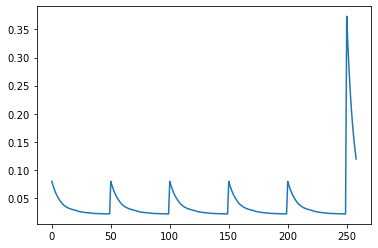

In [82]:
plt.plot(resSGD_dif_loc[1][:400])

In [152]:
[resSGD_dif_loc[1][i*50] for i in range(5)]

[0.07436313480138779,
 0.3727584779262543,
 0.4245162904262543,
 0.414076566696167,
 0.40010538697242737]

In [151]:
resSGD_dif_loc[1]

[0.07436313480138779,
 0.0683533102273941,
 0.06276807188987732,
 0.05791870504617691,
 0.05381419137120247,
 0.05034014210104942,
 0.04739970341324806,
 0.044910915195941925,
 0.04266491159796715,
 0.040129225701093674,
 0.037932898849248886,
 0.03571222350001335,
 0.033832650631666183,
 0.03224177286028862,
 0.030895253643393517,
 0.029755566269159317,
 0.028790926560759544,
 0.027974460273981094,
 0.027283404022455215,
 0.02669849433004856,
 0.026179907843470573,
 0.02525121532380581,
 0.024465171620249748,
 0.02379986084997654,
 0.023236742243170738,
 0.022760121151804924,
 0.022356709465384483,
 0.02201525680720806,
 0.021726256236433983,
 0.021481644362211227,
 0.02127460576593876,
 0.02109936811029911,
 0.020951047539711,
 0.020825505256652832,
 0.020719250664114952,
 0.020629314705729485,
 0.020549379289150238,
 0.020350158214569092,
 0.020181534811854362,
 0.020038815215229988,
 0.019918013364076614,
 0.01981576718389988,
 0.01972922682762146,
 0.01965598203241825,
 0.01959398

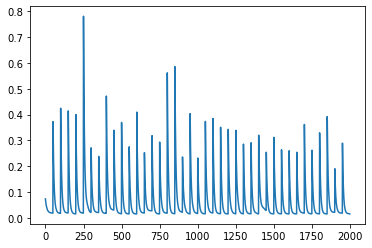

In [130]:
plt.plot(resSGD_dif_loc[1])

In [114]:
resSGD_dif_loc[3][-15:].transpose().shape

(20, 15)

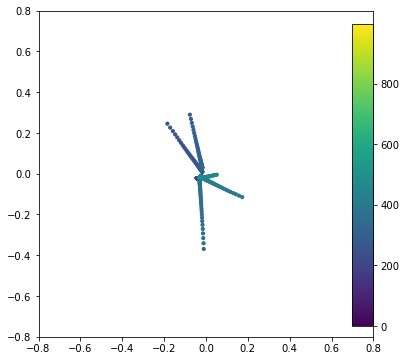

In [39]:
scatter2d(resSGD_dif_loc[3])

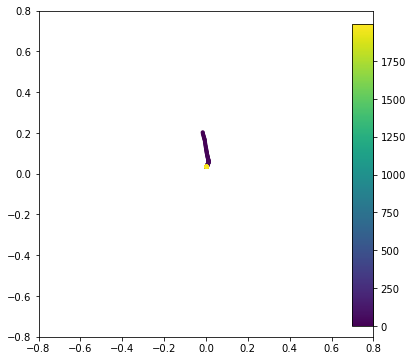

In [119]:
scatter2d(resSGD_dif_loc[3])

In [117]:
cma_pca_2.singular_values_

array([2.3130212, 0.5871402], dtype=float32)

In [116]:
cma_pca_2 = PCA(n_components=2)
cma_pca_2.fit(resSGD_dif_loc[3][-15:].transpose())
pca_result_cma = cma_pca_2.transform(resSGD_dif_loc[3][-15:].transpose())

In [109]:
np.linalg.svd(resSGD_dif_loc[3][-15:])

(array([[-2.37717554e-01, -5.14750779e-02,  3.78527164e-01,
         -2.69775242e-01, -1.09924592e-01,  3.36544365e-01,
          1.67236239e-01,  8.82498268e-03, -4.67152178e-01,
          1.03330791e-01, -4.16483730e-01,  9.29513574e-02,
         -2.40140613e-02, -7.09276125e-02, -3.93412471e-01],
        [-2.73296863e-01,  3.21905583e-01,  8.76224339e-02,
         -1.23023428e-01, -3.91669646e-02, -3.41928184e-01,
          2.60123834e-02, -1.91967309e-01,  4.39899504e-01,
         -8.45098570e-02, -6.15522921e-01, -2.02898547e-01,
          1.57526750e-02,  1.39530361e-01,  4.98948619e-02],
        [-2.45208234e-01, -1.42683879e-01, -6.61804080e-02,
          8.26987401e-02, -2.47805063e-02,  2.71218140e-02,
         -9.80772972e-02, -5.62176108e-03,  7.20605403e-02,
          2.35908866e-01,  1.34859815e-01, -6.28709018e-01,
         -5.72214782e-01, -2.32916906e-01, -2.03241199e-01],
        [-2.76238501e-01,  2.27763563e-01,  4.53625679e-01,
          6.92101046e-02, -3.22562397

In [86]:
np.array(resSGD_dif_loc[3]).shape

(99, 1, 2)

In [13]:
def method4_to_arbitatry_loss(points, ply_mesh, model, constraint_rad=0.1, axis=0):
    initial_dir = points.grad.clone()
    points.grad.data.zero_()
    #points.requires_grad_(False)
    mesh = transform_mesh(points, ply_mesh, AvgTransform)
    #mesh['x'] = mesh['x'].detach().requires_grad_(True)
    local_preds = model(mesh)
    loss = calculate_loss(mesh, local_preds, constraint_rad=constraint_rad)
    loss.backward()

    sign = [-p1.dot(p2) for p1, p2 in zip(initial_dir, points.grad)]
    
    return sign, loss, local_preds, mesh

def optimize_shape_deepSDF(decoder, latent, initial_points=None, num_points=None, 
                           num_iters=100, point_iters=100, num_neignours_constr=10,
                           lr=0.2, decreased_by=2, adjust_lr_every=10, alpha_penalty=0.05,
                           multiplier_func=method4_to_arbitatry_loss, verbose=None, save_to_dir=None, N=256):

    def adjust_learning_rate(
        initial_lr, optimizer, num_iterations, decreased_by, adjust_lr_every
    ):
        lr = initial_lr * ((1 / decreased_by) ** (num_iterations // adjust_lr_every)) \
                        * ((punch_lr_at_reindex_by) ** (num_iterations // reindex_latent_each))
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
            
        return lr
    
    if not os.path.exists(os.path.join(save_to_dir, 'meshes')):
        os.makedirs(os.path.join(save_to_dir, 'meshes'))
    if not os.path.exists(os.path.join(save_to_dir, 'predictions')):
        os.makedirs(os.path.join(save_to_dir, 'predictions'))

    ref_latent = latent.clone().detach()
    decoder.eval()
    latent = latent.clone()
    latent.requires_grad = True
    optimizer = cma_es(dim=256)
    optParas ={'x0': latent,
           'std': torch.ones((256,), device=torch.device('cuda:0')) * 0.03, 
           'tol': 1e-6, 
           'adjust_func': None, 
           'record': True, 
           'max_iter': 50,
           'cluster_size': 6,
           'verbose': True}
    optimizer.set_parameters(optParas)
    optimizer.init(latent)
    #inner_opt = torch.optim.SGD([latent], lr=lr)
    #inner_opt.zero_grad()
    #optimizer.add_inner(inner_opt)
    loss_plot = []
    penalty_plot = []
    latent_plot = []
    math_loss_plot = []
    for i in range(num_iters):
        time_start = time.time()
        
        #cur_rl = adjust_learning_rate(lr, inner_opt, i, decreased_by, adjust_lr_every)

            
        start = time.time()
        with torch.no_grad():
            ply_mesh = create_mesh( decoder,
                                    latent,
                                    N=N,
                                    max_batch=int(2 ** 18),
                                    offset=None,
                                    scale=None)
        end = time.time()
        print("mesh time: %.1f "%(end-start))

        points = torch.tensor(np.hstack(( ply_mesh['vertex']['x'][:, None], 
                                                    ply_mesh['vertex']['y'][:, None], 
                                                    ply_mesh['vertex']['z'][:, None]))).cuda(1)
        
        points.requires_grad = True

        sdf_value = decode_sdf(decoder, latent, points)
        sdf_value.backward(torch.ones([len(points), 1], dtype=torch.float32).cuda(1))

        mults, loss_value, preds, transformed_mesh = multiplier_func(points, ply_mesh)         
        multipliers = torch.cuda.FloatTensor(mults).cuda(1)
    
        latent.grad.zero_()
        sdf_value = torch.squeeze(decode_sdf(decoder, latent, points.detach()))
    
        final_loss = torch.sum(sdf_value * multipliers)
        
        
        #final_loss.backward()
       # first_deri = torch.norm(latent.grad).item()
        first_d = latent.grad.clone().squeeze()
        

        # Soft-constraints
        distances, indeces = LATENT_KD_TREE.query(latent.cpu().detach(), k=num_neignours_constr)
        apenalty = alpha_penalty * torch.sum((latent - latent_vectors[indeces.squeeze()]) ** 2, dim=2).mean()
        #apenalty.backward()
        #sum_d = latent.grad.squeeze()
        #second_d = sum_d - first_d
        #second_deri = torch.norm(second_d).item()



        math_loss = (apenalty + final_loss).detach()

        #save_path = os.path.join(save_to_dir, 'meshes/' + str(i).zfill(5) + ".ply")
        #preds_save_path = os.path.join(save_to_dir, 'predictions/' + str(i).zfill(5) + ".npy")
        #tri_mesh = get_trimesh_from_torch_geo_with_colors(transformed_mesh, preds)
        #tri_mesh.export(save_path)
        #np.save(preds_save_path, preds[:,0].cpu().detach().numpy())
        #np.save(os.path.join(save_to_dir, "latent_plot.npy"), latent_plot)    

        
        latent = optimizer.step(i, latent, math_loss.item(), None)
        latent = latent.detach().requires_grad_(True)
        
        #inner_opt.step()
        end_end = time.time()
        
        print("backward time: %.2f"%(end_end-end))
        
        math_loss_plot.append(math_loss)
        penalty_plot.append(apenalty)
        loss_plot.append(loss_value.cpu().detach().numpy())
        latent_plot.append(latent.clone())
        np.save(os.path.join(save_to_dir, "phy_loss_plot.npy"), loss_plot)    
        np.save(os.path.join(save_to_dir, "latent_series.npy"), latent_plot)    
        np.save(os.path.join(save_to_dir, "math_loss_plot.npy"), math_loss_plot)   

        
        if verbose is not None and i % verbose == 0:
            print('Iter ', i)
            #print("gradient: first %.3f second %.3f, full %.3f, angle %.2f "%(first_deri, second_deri, \
            #    torch.norm(sum_d), 90 / np.pi * torch.acos(first_d.dot(second_d) / torch.norm(first_d)/torch.norm(second_d))))
            print('phys Loss: %.5f'%loss_value.item())
            print('apenality: %.4f'%apenalty.item())
            print("math_loss: %.4f"%((apenalty + final_loss).item()))
        print("\n")
        if i > 2 and np.abs(loss_plot[-1] - loss_plot[-2]) < 1e-4:
            print("one time of low progress!")
            #break
        
    return loss_plot, math_loss_plot, penalty_plot, latent_plot



def make_full_transformation(initial_latent, experiment_name, 
                             decoder, model, alpha_penalty=0.05, constraint_rad=0.1, axis=0, **kwargs):
    '''
    kwargs:
        num_iters=1000, 
        adjust_lr_every=10, 
        decreased_by=1.2,
        lr=0.005
        verbose=10,
    '''

    #ref_points = get_points_from_latent(decoder, ref_latent, N=128)
    save_to_dir = experiment_name
    if not os.path.exists(save_to_dir):
        os.makedirs(save_to_dir)

    #np.save(os.path.join(save_to_dir, "target_verts.npy"), ref_points)

    return optimize_shape_deepSDF(decoder, initial_latent, initial_points=None,
                                           alpha_penalty=alpha_penalty,
                                           num_points=None, point_iters=2,
                                           multiplier_func=lambda x, y: 
                                               method4_to_arbitatry_loss(x, y, model, 
                                                                         constraint_rad=constraint_rad, 
                                                                         axis=axis),
                                           save_to_dir=save_to_dir, **kwargs)
   

In [14]:

class cma_es():
    def __init__(self, dim=2):
        self.dim = dim
        paras = {'x0': torch.zeros((dim,)),
                 'std': torch.ones((dim,)) * 3, 
                 'tol': 1e-5, 
                 'adjust_func': None, 
                 'record': False, 
                 'verbose': False}
        self.set_parameters(paras)
    def set_parameters(self, paras):
        self.paras = paras
        self.x0 = paras['x0'] 
        self.std = paras['std']
        self.tol = paras['tol']
        self.adjust_func = paras['adjust_func']
        self.max_iter = 400 if 'max_iter' not in paras.keys() else paras['max_iter']
        # set none to use default value 
        self.cluster_size = None if 'cluster_size' not in paras.keys() else paras['cluster_size']
        self.survival_size = None if 'survival_size' not in paras.keys() else paras['survival_size']
        self.record = True if 'record' not in paras.keys() else paras['record']
        self.verbose = True if 'verbose' not in paras.keys() else paras['verbose']
    def optimise(self, obj):
        '''
        @param obj: objective function class instance
        return arg: found minimum arguments
               val: found minimum value
               stats: collection of recorded statistics for post-analysis
        '''                  
        def update_mean(x):
            return (weights @ x).reshape(dim, 1)
        def update_ps(ps, sigma, C, mean, mean_old):
            return (1 - cs) * ps + torch.sqrt(cs * (2 - cs) * mueff) * invsqrtC @ (mean - mean_old) / sigma 
        def update_pc(pc, sigma, ps, mean, mean_old):
            hsig = (torch.norm(ps) / torch.sqrt(1 - (1 - cs)**(2 * iter_/lambda_)) / chiN < 1.4 + 2/(dim + 1)).int()
            return (1 - cc) * pc + hsig * torch.sqrt(cc * (2 - cc) * mueff) * (mean - mean_old) / sigma
        def update_C(C, pc, x, mean_old, sigma):
            hsig = (torch.norm(ps) / torch.sqrt(1 - (1 - cs)**(2 * iter_/lambda_)) / chiN < (1.4 + 2/(dim + 1))).int()
            artmp = (1 / sigma) * (x - mean_old.reshape(1, dim))
            return (1 - c1 - cmu) * C + c1 * (pc * pc.transpose(1,0) + (1 - hsig) * cc * (2 - cc) * C) + cmu * artmp.transpose(1,0) @ torch.diag(weights) @ artmp
        def update_sigma(sigma, ps):
            return sigma * torch.exp((cs / damps) * (torch.norm(ps)/ chiN - 1))
        def is_not_moving(arg, val, pre_arg, pre_val, tol):
            dis_arg = torch.norm(arg - pre_arg, dim=1).mean()
            dis_val = torch.abs(val - pre_val).mean()
            return (dis_arg < tol and dis_val < tol) 

        if self.verbose:
            print("\n\n*******starting optimisation from intitial mean: ", torch.norm(self.x0).detach().cpu().numpy())
        # User defined input parameters 
        dim = self.dim
        sigma = 0.3
        D = self.std / sigma
        mean = self.x0.reshape(dim, 1).detach()
        # the size of solutions group
        lambda_ = 4 + int(3 * np.log(dim)) if self.cluster_size == None else self.cluster_size  
        # only best "mu" solutions are used to generate iterations
        mu = int(lambda_ / 2) if self.survival_size == None else self.survival_size
        # used to combine best "mu" solutions                                               
        weights = torch.log(mu + 1/2) - torch.log(torch.arange(mu, dtype=torch.float) + 1) 
        weights = (weights / torch.sum(weights)).cuda()   
        mueff = 1 / torch.sum(weights**2) 

        # Strategy parameter setting: Adaptation
        # time constant for cumulation for C
        cc = (4 + mueff / dim) / (dim + 4 + 2 * mueff / dim)  
        # t-const for cumulation for sigma control
        cs = (mueff + 2) / (dim + mueff + 5)  
        # learning rate for rank-one update of C
        c1 = 2 / ((dim + 1.3)**2 + mueff)    
        # and for rank-mu update
        cmu = min(1 - c1, 2 * (mueff - 2 + 1 / mueff) / ((dim + 2)**2 + mueff))  
        # damping for sigma, usually close to 1  
        damps = 1 + 2 * max(0, torch.sqrt((mueff - 1)/( dim + 1)) - 1) + cs     


        # Initialize dynamic (internal) strategy parameters and constants
        # evolution paths for C and sigma
        pc = torch.zeros((dim, 1), device=torch.device('cuda:0'))     
        ps = torch.zeros((dim, 1), device=torch.device('cuda:0')) 
        # B defines the coordinate system
        B = torch.eye(int(dim), device=torch.device('cuda:0'))       
        # covariance matrix C
        C = B * torch.diag(D**2) * B.transpose(1, 0)
        # C^-1/2 
        invsqrtC = B * torch.diag(D**-1) * B.transpose(1, 0)
        # expectation of ||N(0,I)|| == norm(randn(N,1)) 
        chiN = dim**0.5 * (1 - 1/(4 * dim) + 1 / (21 * dim**2))  

        # --------------------  Initialization --------------------------------  
        x, x_old, fs = torch.zeros((lambda_, dim), device=torch.device('cuda:0')),  \
                        torch.zeros((lambda_, dim), device=torch.device('cuda:0')), \
                        torch.zeros((lambda_,), device=torch.device('cuda:0'))
        stats = {}
        inner_stats = {}
        stats['inner'] = []
        stats['val'], stats['arg'] = [], []
        stats['x_adjust'] = []
        iter_eval, stats['evals'] = torch.zeros((lambda_,)), []
        inner_stats = [{}] * lambda_
        stats['mean'], stats['std'] = [], []
        stats['status'] = None
        iter_, eval_ = 0, 0
        # initial data in record
        cand = mean.squeeze()
        #fs[0] = obj.func(cand)
        for i in range(lambda_):
            fs[i] = 100
            x[i] = cand
            x_old[i] = cand
        idx = 0
        x_ascending = x[idx]
        arg = None
        val = fs[idx]
        pre_arg = x_ascending
        pre_val = fs[idx]
        best_val = fs[0] + 1e2
        best_arg = x[0,:]
        sum_eval = 0
        # optimise by iterations
        while iter_ < self.max_iter:
            iter_ += 1
            # generate candidate solutions with some stochastic elements
            for i in range(lambda_):
                candidate_old = (mean + sigma * B @ torch.diag(D) @ torch.randn(dim, 1).cuda()).reshape(1,-1)
                print("candidate: ", candidate_old.shape)
                print(candidate_old)
                candidate_new, val, inner_stats[i] = obj.func(candidate_old.requires_grad_(True))
                del candidate_old 
                x[i] = candidate_new.detach()
                fs[i] = val.detach()

                eval_ += inner_stats[i]['evals']
                iter_eval[i] = inner_stats[i]['evals']
           # sort the value and positions of solutions 
            idx = torch.argsort(fs)
            x_ascending = x[idx]

            # update the parameter for next iteration
            mean_old = mean
            mean = update_mean(x_ascending[:mu])
            # print("mean old and new: ", mean_old, mean)
            ps =   update_ps(ps, sigma, C, mean, mean_old)
            pc =   update_pc(pc, sigma, ps, mean, mean_old)
            sigma = update_sigma(sigma, ps)

            C =    update_C(C, pc, x_ascending[:mu], mean_old, sigma)
            C = (torch.triu(C) + torch.triu(C, 1).transpose(1,0))
            D, B = torch.eig(C, eigenvectors=True)
            D = torch.sqrt(D[:,0])
            invsqrtC = B @ torch.diag(D**-1) @ B.transpose(1,0)
            arg = x_ascending
            val = fs[idx]
            if self.verbose:
                print("**************** cma iter: ", iter_, "**********************")
                print("loss: %.5f"%val[0].item())
                print("evals: ", iter_eval.sum())
                #print("latent: ", x_ascending[0].cpu().numpy())
                #print("mean: ", mean)
                #print("sigma: ", sigma)
                #print("std: ", D)
                print("\n")
            # record data during process for post analysis
            if self.record:
                #stats['inner'].append(inner_stats)
                stats['arg'].append(x_ascending[0].cpu().numpy())
                stats['val'].append(fs[idx].detach().cpu().numpy())
                #stats['mean'].append(mean.cpu().numpy())
                #stats['std'].append((sigma * B @ torch.diag(D)).cpu().numpy())
                sum_eval += iter_eval.sum() 
                stats['evals'].append(sum_eval)
                #stats['x_adjust'].append(np.vstack((x.transpose(1,0).cpu().numpy(), x_old.transpose(1,0).cpu().numpy())))
            # stopping condition  
            if best_val > val[0]:
                best_val = val[0]
                best_arg = arg[0]              
            # check the stop condition
            if torch.max(D) > (torch.min(D) * 1e4):
                stats['status'] = 'diverge'
                print('diverge, concentrate in low dimension manifold')
                break
            if is_not_moving(arg, val, pre_arg, pre_val, self.tol) :
                break
            pre_arg = arg
            pre_val = val
        if self.verbose:
            #print('eigenvalue of variance = {}'.format(D))
            print('total iterations = {}, total evaluatios = {}'.format(iter_, eval_))
            print('found minimum position = {}, found minimum = {}'.format(best_arg.detach().cpu().numpy()[:10], best_val.detach().cpu().numpy()))

        # carry statistics info before quit
        if self.record:
            stats['arg'] = np.array(stats['arg'])
            stats['val'] = np.array(stats['val'])
            #stats['mean'] = np.array(stats['mean'])
            #stats['std'] = np.array(stats['std'])
            stats['evals'] = np.array(stats['evals'])
            #stats['x_adjust'] = np.array(stats['x_adjust'])
        stats['evals'] = eval_
        return best_arg, best_val, stats
    
    def update_mean(self, xs):
        print(self.WEIGHTS.shape, xs.shape)
        return (self.WEIGHTS @ xs).reshape(self.DIM, 1)
    def update_ps(self):
        return (1 - self.CS) * self.ps + torch.sqrt(self.CS * (2 - self.CS) * self.MUEFF) * self.invsqrtC @ (self.mean - self.mean_old) / self.sigma 
    def update_pc(self, iter_):
        hsig = (torch.norm(self.ps) / torch.sqrt(1 - (1 - self.CS)**(2 * iter_/self.LAMBDA_)) / self.chiN < 1.4 + 2/(self.DIM + 1)).int()
        return (1 - self.CC) * self.pc + hsig * torch.sqrt(self.CC * (2 - self.CC) * self.MUEFF) * (self.mean - self.mean_old) / self.sigma
    def update_C(self, iter_, xs):
        hsig = (torch.norm(self.ps) / torch.sqrt(1 - (1 - self.CS)**(2 * iter_/self.LAMBDA_)) / self.chiN < (1.4 + 2/(self.DIM + 1))).int()
        artmp = (1 / self.sigma) * (xs - self.mean_old.reshape(1, self.DIM))
        return (1 - self.C1 - self.CMU) * self.c + self.C1 *  \
                (self.pc * self.pc.transpose(1,0) + (1 - hsig) * self.CC * \
                (2 - self.CC) * self.c) + self.CMU * artmp.transpose(1,0) @  \
                torch.diag(self.WEIGHTS) @ artmp
    def update_sigma(self):
        return self.sigma * torch.exp((self.CS / self.DAMPS) * (torch.norm(self.ps)/ self.chiN - 1))

    def init(self, latent):

        # User defined input parameters 
        self.DIM = latent.shape[1]
        # the size of solutions group
        self.LAMBDA_ = 4 + int(3 * torch.log(torch.tensor(self.DIM))) if self.cluster_size == None else self.cluster_size  
        # only best "mu" solutions are used to generate iterations
        self.MU = int(self.LAMBDA_ / 2) if self.survival_size == None else self.survival_size
        # used to combine best "mu" solutions                                               
        self.WEIGHTS = torch.log(torch.tensor(self.MU + 1/2)) - torch.log(torch.arange(self.MU, dtype=torch.float) + 1) 
        self.WEIGHTS = (self.WEIGHTS / torch.sum(self.WEIGHTS)).cuda()   
        self.MUEFF = 1 / torch.sum(self.WEIGHTS**2) 

        # Strategy parameter setting: Adaptation
        # time constant for cumulation for C
        self.CC = (4 +self. MUEFF / self.DIM) / (self.DIM + 4 + 2 * self.MUEFF / self.DIM)  
        # t-const for cumulation for sigma control
        self.CS = (self.MUEFF + 2) / (self.DIM + self.MUEFF + 5)  
        # learning rate for rank-one update of C
        self.C1 = 2 / ((self.DIM + 1.3)**2 + self.MUEFF)    
        # and for rank-mu update
        self.CMU = min(1 - self.C1, 2 * (self.MUEFF - 2 + 1 / self.MUEFF) / ((self.DIM + 2)**2 + self.MUEFF))  
        # damping for sigma, usually close to 1  
        self.DAMPS = 1 + 2 * max(0, torch.sqrt((self.MUEFF - 1)/( self.DIM + 1)) - 1) + self.CS     
        self.chiN = self.DIM**0.5 * (1 - 1/(4 * self.DIM) + 1 / (21 * self.DIM**2))  

        
        self.sigma = 0.3
        self.d = self.std / self.sigma
        self.mean = latent.detach().reshape(self.DIM,1)
        # Initialize dynamic (internal) strategy parameters and constants
        # evolution paths for C and sigma
        self.pc = torch.zeros((self.DIM, 1), device=torch.device('cuda:0'))     
        self.ps = torch.zeros((self.DIM, 1), device=torch.device('cuda:0')) 
        # B defines the coordinate system
        self.b = torch.eye(int(self.DIM), device=torch.device('cuda:0'))       
        # covariance matrix C
        self.c = self.b * torch.diag(self.d**2) * self.b.transpose(1, 0)
        # C^-1/2 
        self.invsqrtC = self.b * torch.diag(self.d**-1) * self.b.transpose(1, 0)
        # expectation of ||N(0,I)|| == norm(randn(N,1)) 
        self.xs = []
        self.fs = []
        self.j = 0
    def add_inner(self, opt):
        self.opt = opt
    def step(self, i, x, val, grad):
        if i % 10 != 0 or i == 0:
            opt = torch.optim.SGD([x], lr=0.2)
            opt.step()
            return x
        elif i % (10*self.LAMBDA_) != 0:
            self.xs.append(x.detach().squeeze())
            self.fs.append(val)
        else:
            idx = torch.argsort(torch.tensor(self.fs))
            x_ascending = torch.stack(self.xs)[idx]

            # update the parameter for next iteration
            self.mean_old = self.mean
            self.mean = self.update_mean(x_ascending[:self.MU])
            self.ps = self.update_ps()
            self.pc = self.update_pc(i)
            self.sigma = self.update_sigma()
            self.c = self.update_C(i, x_ascending[:self.MU])
            self.c = (torch.triu(self.c) + torch.triu(self.c, 1).transpose(1,0))
            self.d, self.b = torch.eig(self.c, eigenvectors=True)
            self.d = torch.sqrt(self.d[:,0])
            self.invsqrtC = self.b @ torch.diag(self.d**-1) @ self.b.transpose(1,0)
            self.xs = []
            self.fs = []
            self.j += 1
            print("********** %d th iter of CMA completed************"%(self.j))
        x_new = (self.mean + self.sigma * self.b @ torch.diag(self.d)  \
                 @ torch.randn(self.DIM, 1).cuda()).reshape(1,-1)
        return x_new.reshape(1, self.DIM)

In [15]:
def method4_to_arbitatry_loss(points, ply_mesh, model, constraint_rad=0.1, axis=0):
    initial_dir = points.grad.clone()
    points.grad.data.zero_()
    #points.requires_grad_(False)
    mesh = transform_mesh(points, ply_mesh, AvgTransform)
    #mesh['x'] = mesh['x'].detach().requires_grad_(True)
    local_preds = model(mesh)
    loss = calculate_loss(mesh, local_preds, constraint_rad=constraint_rad)
    loss.backward()
    #/torch.norm(points.grad)
    sign = [-p1.dot(p2) for p1, p2 in zip(initial_dir, points.grad)]
    
    return sign, loss, local_preds, mesh



def optimize_shape_deepSDF(decoder, latent, initial_points=None, num_points=None, 
                           num_iters=100, point_iters=100, num_neignours_constr=10,
                           lr=0.2, decreased_by=2, adjust_lr_every=10, alpha_penalty=0.05,
                           multiplier_func=method4_to_arbitatry_loss, verbose=None, save_to_dir=None, N=256):

    def adjust_learning_rate(
        initial_lr, optimizer, num_iterations, decreased_by, adjust_lr_every
    ):
        lr = initial_lr * ((1 / decreased_by) ** (num_iterations // adjust_lr_every)) \
                        * ((punch_lr_at_reindex_by) ** (num_iterations // reindex_latent_each))
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
            
        return lr
    
    if not os.path.exists(os.path.join(save_to_dir, 'meshes')):
        os.makedirs(os.path.join(save_to_dir, 'meshes'))
    if not os.path.exists(os.path.join(save_to_dir, 'predictions')):
        os.makedirs(os.path.join(save_to_dir, 'predictions'))

    ref_latent = latent.clone().detach()
    decoder.eval()
    latent = latent.clone()
    latent.requires_grad = True
    optimizer = torch.optim.SGD([latent], lr=lr)

    loss_plot = []
    penalty_plot = []
    latent_plot = []
    math_loss_plot = []
    for i in range(num_iters):

        time_start = time.time()
        optimizer.zero_grad()
        
        cur_rl = adjust_learning_rate(lr, optimizer, i, decreased_by, adjust_lr_every)

            
        start = time.time()
        with torch.no_grad():
            ply_mesh = create_mesh( decoder,
                                    latent,
                                    N=N,
                                    max_batch=int(2 ** 18),
                                    offset=None,
                                    scale=None)
        end = time.time()
        print("mesh time: %.1f "%(end-start))

        points = torch.tensor(np.hstack(( ply_mesh['vertex']['x'][:, None], 
                                                    ply_mesh['vertex']['y'][:, None], 
                                                    ply_mesh['vertex']['z'][:, None]))).cuda(1)
        
        points.requires_grad = True

        sdf_value = decode_sdf(decoder, latent, points)
        torch.sum(sdf_value).backward()

        mults, loss_value, preds, transformed_mesh = multiplier_func(points, ply_mesh)         
        multipliers = torch.cuda.FloatTensor(mults).cuda(1)

        optimizer.zero_grad()
        sdf_value = torch.squeeze(decode_sdf(decoder, latent, points.detach()))
    
        final_loss = torch.sum(sdf_value * multipliers)
        final_loss.backward()
        first_deri = torch.norm(latent.grad).item()
        first_d = latent.grad.clone().squeeze()
        

        # Soft-constraints
        distances, indeces = LATENT_KD_TREE.query(latent.cpu().detach(), k=num_neignours_constr)
        apenalty = alpha_penalty * torch.sum((latent - latent_vectors[indeces.squeeze()]) ** 2, dim=2).mean()
        apenalty.backward()
        second_deri = torch.norm(latent.grad-first_d).item()
        second_d = latent.grad.squeeze()-first_d


        math_loss = (apenalty + final_loss).item()
        optimizer.step()

        end_end = time.time()
        print("NN time: %.1f"%(end_end-end))
        
        #save_path = os.path.join(save_to_dir, 'meshes/' + str(i).zfill(5) + ".ply")
        #preds_save_path = os.path.join(save_to_dir, 'predictions/' + str(i).zfill(5) + ".npy")
        #tri_mesh = get_trimesh_from_torch_geo_with_colors(transformed_mesh, preds)
        #tri_mesh.export(save_path)
        #np.save(preds_save_path, preds[:,0].cpu().detach().numpy())

        math_loss_plot.append(math_loss)
        penalty_plot.append(apenalty)
        loss_plot.append(loss_value.cpu().detach().numpy())
        latent_plot.append(latent.clone())
        np.save(os.path.join(save_to_dir, "phy_loss_plot.npy"), loss_plot)    
        np.save(os.path.join(save_to_dir, "latent_series.npy"), latent_plot)    
        np.save(os.path.join(save_to_dir, "math_loss_plot.npy"), math_loss_plot)   

        
        if verbose is not None and i % verbose == 0:
            print('Iter ', i)
            print("gradient: first %.3f second %.3f, full %.3f, angle %.2f "%(first_deri, second_deri, \
                torch.norm(latent.grad), 90 / np.pi * torch.acos(first_d.dot(second_d) / torch.norm(first_d)/torch.norm(second_d))))
            print('phys Loss: %.5f'%loss_value.item())
            print('apenality: %.4f'%apenalty.item())
            print("math_loss: %.4f"%((apenalty + final_loss).item()))
        print("\n")
        if i > 2 and np.abs(loss_plot[-1] - loss_plot[-2]) < 1e-4:
            print("one time of low progress!")
            #break
    return loss_plot, math_loss_plot, penalty_plot, latent_plot



def make_full_transformation(initial_latent, experiment_name, 
                             decoder, model, alpha_penalty=0.05, constraint_rad=0.1, axis=0, **kwargs):
    '''
    kwargs:
        num_iters=1000, 
        adjust_lr_every=10, 
        decreased_by=1.2,
        lr=0.005
        verbose=10,
    '''

    #ref_points = get_points_from_latent(decoder, ref_latent, N=128)
    save_to_dir = experiment_name
    if not os.path.exists(save_to_dir):
        os.makedirs(save_to_dir)

    #np.save(os.path.join(save_to_dir, "target_verts.npy"), ref_points)

    return optimize_shape_deepSDF(decoder, initial_latent, initial_points=None,
                                           alpha_penalty=alpha_penalty,
                                           num_points=None, point_iters=2,
                                           multiplier_func=lambda x, y: 
                                               method4_to_arbitatry_loss(x, y, model, 
                                                                         constraint_rad=constraint_rad, 
                                                                         axis=axis),
                                           save_to_dir=save_to_dir, **kwargs)
   

In [ ]:
LATENT_TO_OPTIMIZE = latent_vectors[32]
DIR_for_dump_data = './long_adam'
punch_lr_at_reindex_by=1
reindex_latent_each = 10000

np.random.seed(101)
torch.manual_seed(0)
%time resAdamss = make_full_transformation(LATENT_TO_OPTIMIZE.detach(), \
                         experiment_name=DIR_for_dump_data, decoder=decoder, model=predictor, \
                         alpha_penalty=0.2, axis=0, \
                         constraint_rad=0.05, \
                         num_iters=100, \
                         adjust_lr_every=20, \
                         decreased_by=1.1, \
                         lr=0.2, \
                         verbose=1, \
                         N=256, \
                         num_neignours_constr=10)

mesh time: 11.3 
three parts (321) of loss: 0.000, 0.000, 0.097
NN time: 35.6
Iter  0
gradient: first 0.593 second 0.193, full 0.646, angle 41.45 
phys Loss: 0.09732
apenality: 0.0797
math_loss: 0.0796


mesh time: 11.5 
three parts (321) of loss: 0.000, 0.000, 0.086
NN time: 35.4
Iter  1
gradient: first 0.435 second 0.172, full 0.460, angle 46.27 
phys Loss: 0.08640
apenality: 0.0727
math_loss: 0.0725


mesh time: 11.4 
three parts (321) of loss: 0.000, 0.000, 0.090
NN time: 36.1
Iter  2
gradient: first 0.440 second 0.170, full 0.434, angle 51.58 
phys Loss: 0.09033
apenality: 0.0690
math_loss: 0.0689


mesh time: 11.5 
three parts (321) of loss: 0.000, 0.000, 0.096
NN time: 35.1
Iter  3
gradient: first 0.401 second 0.168, full 0.365, angle 57.27 
phys Loss: 0.09632
apenality: 0.0681
math_loss: 0.0680


mesh time: 11.3 
three parts (321) of loss: 0.000, 0.000, 0.098
NN time: 37.6
Iter  4
gradient: first 0.354 second 0.170, full 0.307, angle 59.97 
phys Loss: 0.09806
apenality: 0.0691


In [22]:
LATENT_TO_OPTIMIZE = latent_vectors[32]
DIR_for_dump_data = './long_adam'
punch_lr_at_reindex_by=1
reindex_latent_each = 10000

np.random.seed(101)
torch.manual_seed(0)
%time resAdam = make_full_transformation(LATENT_TO_OPTIMIZE.detach(), \
                         experiment_name=DIR_for_dump_data, decoder=decoder, model=predictor, \
                         alpha_penalty=0.2, axis=0, \
                         constraint_rad=0.05, \
                         num_iters=100, \
                         adjust_lr_every=20, \
                         decreased_by=1.1, \
                         lr=0.2, \
                         verbose=1, \
                         N=256, \
                         num_neignours_constr=10)

mesh time: 11.2 
three parts (321) of loss: 0.000, 0.000, 0.097
NN time: 37.4
Iter  0
gradient: first 0.593 second 0.193, full 0.646, angle 41.45 
phys Loss: 0.09732
apenality: 0.0797
math_loss: 0.0796


mesh time: 11.0 
three parts (321) of loss: 0.000, 0.000, -0.020
NN time: 23.6
Iter  1
gradient: first 0.056 second 1.185, full 1.185, angle 45.65 
phys Loss: -0.02046
apenality: 1.8425
math_loss: 1.8425


mesh time: 11.3 
three parts (321) of loss: 0.000, 0.000, -0.018
NN time: 30.4
Iter  2
gradient: first 0.173 second 0.695, full 0.701, angle 47.61 
phys Loss: -0.01774
apenality: 0.6967
math_loss: 0.6967


mesh time: 11.4 
three parts (321) of loss: 0.000, 0.000, -0.035
NN time: 36.6
Iter  3
gradient: first 0.453 second 0.432, full 0.513, angle 54.61 
phys Loss: -0.03537
apenality: 0.2695
math_loss: 0.2696


mesh time: 11.2 
three parts (321) of loss: 0.000, 0.000, 0.037
NN time: 35.6
Iter  4
gradient: first 0.315 second 0.673, full 0.730, angle 46.39 
phys Loss: 0.03721
apenality: 0

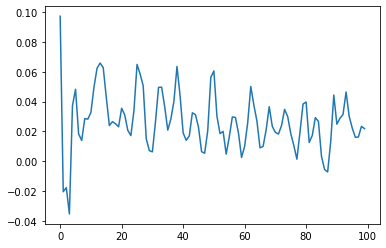

In [26]:
plt.plot(res[0])

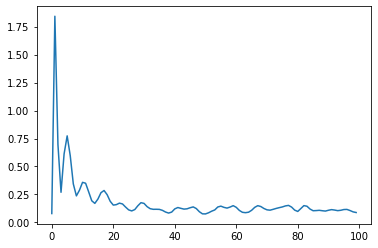

In [66]:
plt.plot(res[1])

In [36]:
np.save("../Compare_optimisers/Adam/phy_loss.npy", res[0])

In [41]:
np.save("../Compare_optimisers/Adam/latent_series.npy", res[3])

In [48]:
#m.export("../Compare_optimisers/Adam/mesh.ply")

In [49]:
#m = visual_Mesh(res[3][-1], 256)
#m.show()

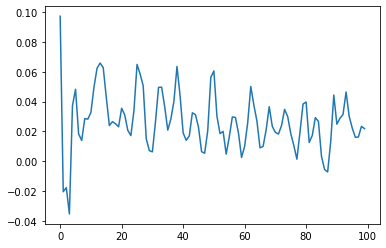

In [43]:
plt.plot(res[0])

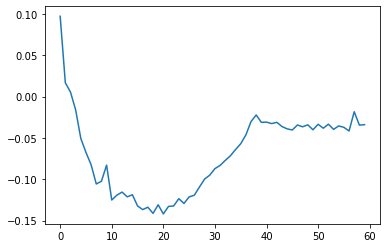

In [31]:
plt.plot(res[0])

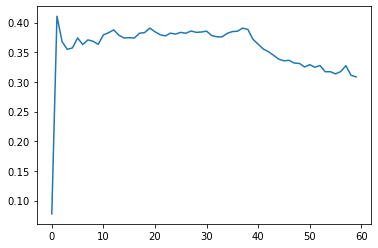

In [34]:
plt.plot(res[1])

In [32]:
visual_Mesh(res[3][20], 256).show()

latent loss. -0.132910 
